In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import glob
import os
import pickle
import random
import sys

import dill
import ivac
import matplotlib as mpl
import matplotlib.pyplot as plt
import mdtraj as md
import numpy as np
import pyemma
import scipy
import seaborn as sns
from matplotlib import ticker

import extq
import prettypyplot as pplt

In [3]:
from joblib import Memory

In [4]:
! source /project/dinner/scguo/upside2/sourceme.sh

In [5]:
# upside_path = os.environ["UPSIDE_HOME"]
upside_path = "/project/dinner/scguo/upside2/"
upside_utils_dir = os.path.expanduser(upside_path + "/py")
sys.path.insert(0, upside_utils_dir)

In [6]:
plt.style.use("custom")  # custom style sheet
plt.style.use("high-contrast")  # muted color theme from SciencePlots
pplt.load_cmaps()

In [7]:
plt.rcParams[
    "text.latex.preamble"
] = r"\usepackage{siunitx}\sisetup{detect-all}\usepackage{helvet}\usepackage{sansmath}\sansmath"
mpl.rcParams["font.family"] = "sans-serif"
mpl.rcParams["font.sans-serif"] = "cm"

# Load data

In [8]:
def get_traj_ids(base_dir):
    ids = []
    k = 0
    for i in range(1, 12289):
        j = i // 1000
        for iso in ("cis", "trans"):
            head = f"{base_dir}/{j:02}/{i:05}/outputs/{i:05}_{iso}"
            if len(glob.glob(f"{base_dir}/{j:02}/{i:05}/{iso}/*.up")) > 0:
                ids.append(k)
            k += 1
    return np.array(ids)


def get_weights(weights, N, k, ids):
    sampled_w = np.concatenate(weights[:, -N::k])
    # set weight for cis/trans to be the same
    sampled_w = np.repeat(sampled_w, 2)
    return sampled_w[ids]


def load_cv(basename):
    arrays = []
    for file in sorted(glob.glob(f"{basename}_??.npy")):
        arrays.append(np.load(file))
    return np.concatenate(arrays)


def load_all(temp):
    base_dir = f"{home_dir}/dga/new_{temp}"
    data_dir = f"{base_dir}/data"
    weights = np.load(f"{data_dir}/mbar_weights.npy")
    ids = get_traj_ids(base_dir)
    N = 32000
    k = 1000
    sample_w = get_weights(weights, N, k, ids)

    fs_qtots = load_cv(f"{data_dir}/fs_qtots")
    q_gs_all = load_cv(f"{data_dir}/q_gs_all")
    q_gs = load_cv(f"{data_dir}/q_gs")
    q_fs_all = load_cv(f"{data_dir}/q_fs_all")
    q_fs = load_cv(f"{data_dir}/q_fs")
    q_core = load_cv(f"{data_dir}/q_core")
    omegas = load_cv(f"{data_dir}/omegas")
    pots = load_cv(f"{data_dir}/pots")
    f_rmsds = load_cv(f"{data_dir}/f_rmsds")
    p_rmsds = load_cv(f"{data_dir}/p_rmsds")

    c_green = fs_qtots[:, 5] - fs_qtots[:, 4]
    c_blue = fs_qtots[:, 7] - fs_qtots[:, 6]
    c_orange = fs_qtots[:, 3] - fs_qtots[:, 2]
    c_0 = fs_qtots[:, 1] - fs_qtots[:, 0]
    n_cis = np.sum((np.abs(omegas[..., 3:]) <= (np.pi / 2.0)).astype(int), axis=-1)

    cvs = dict(
        blue=c_blue,
        green=c_green,
        orange=c_orange,
        c0=c_0,
        q_gs_all=q_gs_all,
        q_fs_all=q_fs_all,
        q_gs=q_gs,
        q_fs=q_fs,
        q_core=q_core,
        n_cis=n_cis,
        pot=pots,
        f_rmsds=f_rmsds,
        p_rmsds=p_rmsds,
        q_diff=q_gs - q_fs,
    )
    return cvs, sample_w

In [9]:
home_dir = "/project/dinner/scguo/kaiB"

In [10]:
cvs_all_ts, weights_all_ts = [], []
qp_all_ts = []
qlag, qmem = 100, 1
for t in [87, 89, 91]:
    cvs, weights = load_all(t)
    cvs_all_ts.append(cvs)
    weights_all_ts.append(weights)
    with open(f"{home_dir}/dga/new_{t}/data/qp_gs2fs.pkl", mode="rb") as f:
        qp_all_ts.append(dill.load(f)[(qlag, qmem)])

In [11]:
qm_all_ts = []
for t in [87, 89, 91]:
    with open(f"{home_dir}/dga/new_{t}/data/qm_gs2fs.pkl", mode="rb") as f:
        qm_all_ts.append(dill.load(f)[(qlag, qmem)])

In [12]:
labels = dict(
    blue=r"$\alpha3_{\mathrm{fs}}\longleftrightarrow\beta4_{\mathrm{gs}}$",
    green=r"$\beta4_{\mathrm{fs}}\longleftrightarrow\alpha3_{\mathrm{gs}}$",
    orange=r"$\beta3_{\mathrm{fs}}\longleftrightarrow\alpha2_{\mathrm{gs}}$",
    c0=r"$\alpha2_{\mathrm{fs}}\longleftrightarrow\beta3_{\mathrm{gs}}$",
    r_rmsd=r"N-term RMSD (nm)",
    q_gs_all=r"$Q_{\mathrm{gs}}$",
    q_fs_all=r"$Q_{\mathrm{fs}}$",
    q_gs=r"$Q_{\mathrm{gs, C}}$",
    q_fs=r"$Q_{\mathrm{fs, C}}$",
    q_core=r"$Q_{\mathrm{N}}$",
    n_cis=r"$n_{\mathrm{cis}}$",
    q_diff=r"$Q_{\mathrm{gs, C}}-Q_{\mathrm{fs, C}}$",
    qp=r"$q_{\mathrm{gs}\rightarrow\mathrm{fs}}$",
)
lims = dict(
    blue=(-1, 1.3),
    green=(-1.3, 1),
    orange=(-1.3, 1),
    c0=(-1, 1.3),
    r_rmsd=(0, 1.2),
    q_gs_all=(0, 1),
    q_fs_all=(0, 1),
    q_gs=(0, 1),
    q_fs=(0, 1),
    q_core=(0, 1),
    n_cis=(0, 2),
    q_diff=(-1, 1),
    qp=(0, 1),
)

/scratch/local/jobs/18029147/ipykernel_929453/2261220693.py:29: RuntimeWarning: invalid value encountered in divide
  pc = ax.pcolormesh(xc, yc, (ew / w).T, cmap="incandescent_r", rasterized=True, vmin=-150, vmax=200)


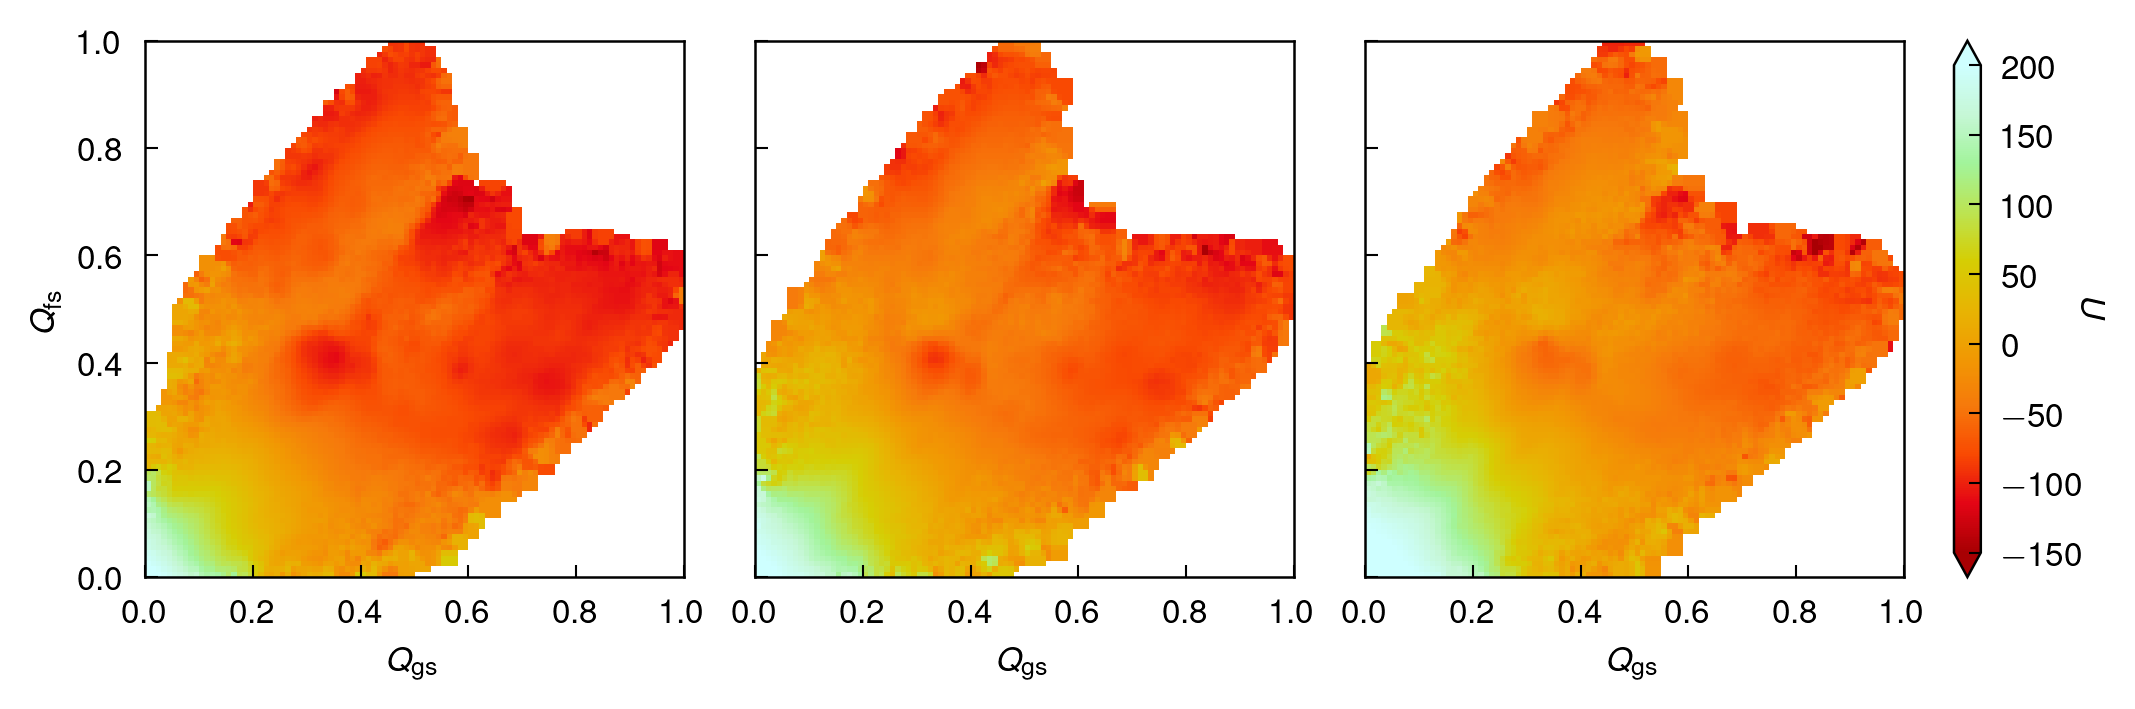

In [13]:
clines = np.arange(0, 14, 2)
fig, axes = plt.subplots(
    nrows=1, ncols=3, figsize=(7, 2.25), dpi=300, sharex=True, sharey=True, constrained_layout=True
)
cv1, cv2 = "q_gs_all", "q_fs_all"
xe = np.linspace(*lims[cv1], 101)
ye = np.linspace(*lims[cv2], 101)
xc = (xe[:-1] + xe[1:]) / 2
yc = (ye[:-1] + ye[1:]) / 2
for ax, cvs, sample_w in zip(axes, cvs_all_ts, weights_all_ts):
    cv1_delay = cvs[cv1]
    cv2_delay = cvs[cv2]
    w = extq.projection.density2d(
        cv1_delay,
        cv2_delay,
        np.broadcast_to(sample_w[..., None], cv1_delay.shape),
        xe,
        ye,
    )
    w = scipy.ndimage.gaussian_filter(w, sigma=0.5, mode="constant")
    ew = extq.projection.density2d(
        cv1_delay,
        cv2_delay,
        np.asarray(cvs["pot"]) * sample_w[..., None],
        xe,
        ye,
    )
    ew = scipy.ndimage.gaussian_filter(ew, sigma=0.5, mode="constant")
    pc = ax.pcolormesh(xc, yc, (ew / w).T, cmap="incandescent_r", rasterized=True, vmin=-150, vmax=200)
    # ax.contour(xc, yc, pmf.T, colors="black", levels=clines, linewidths=0.5)
    ax.set_xlabel(labels[cv1])
    ax.set_ylabel(labels[cv2])
    ax.label_outer()
cb = plt.colorbar(pc, ax=axes[-1], extend="both")
cb.set_label(label="$U$", rotation=-90, labelpad=5)

plt.show()
# plt.savefig("../../dga/figures/pmfs_qgs_qfs_ts.pdf", bbox_inches='tight', dpi=400)

/scratch/local/jobs/18029147/ipykernel_929453/448597027.py:29: RuntimeWarning: invalid value encountered in divide
  pc = ax.pcolormesh(xc, yc, (ew / w).T, cmap="incandescent_r", rasterized=True, vmin=-150, vmax=200)


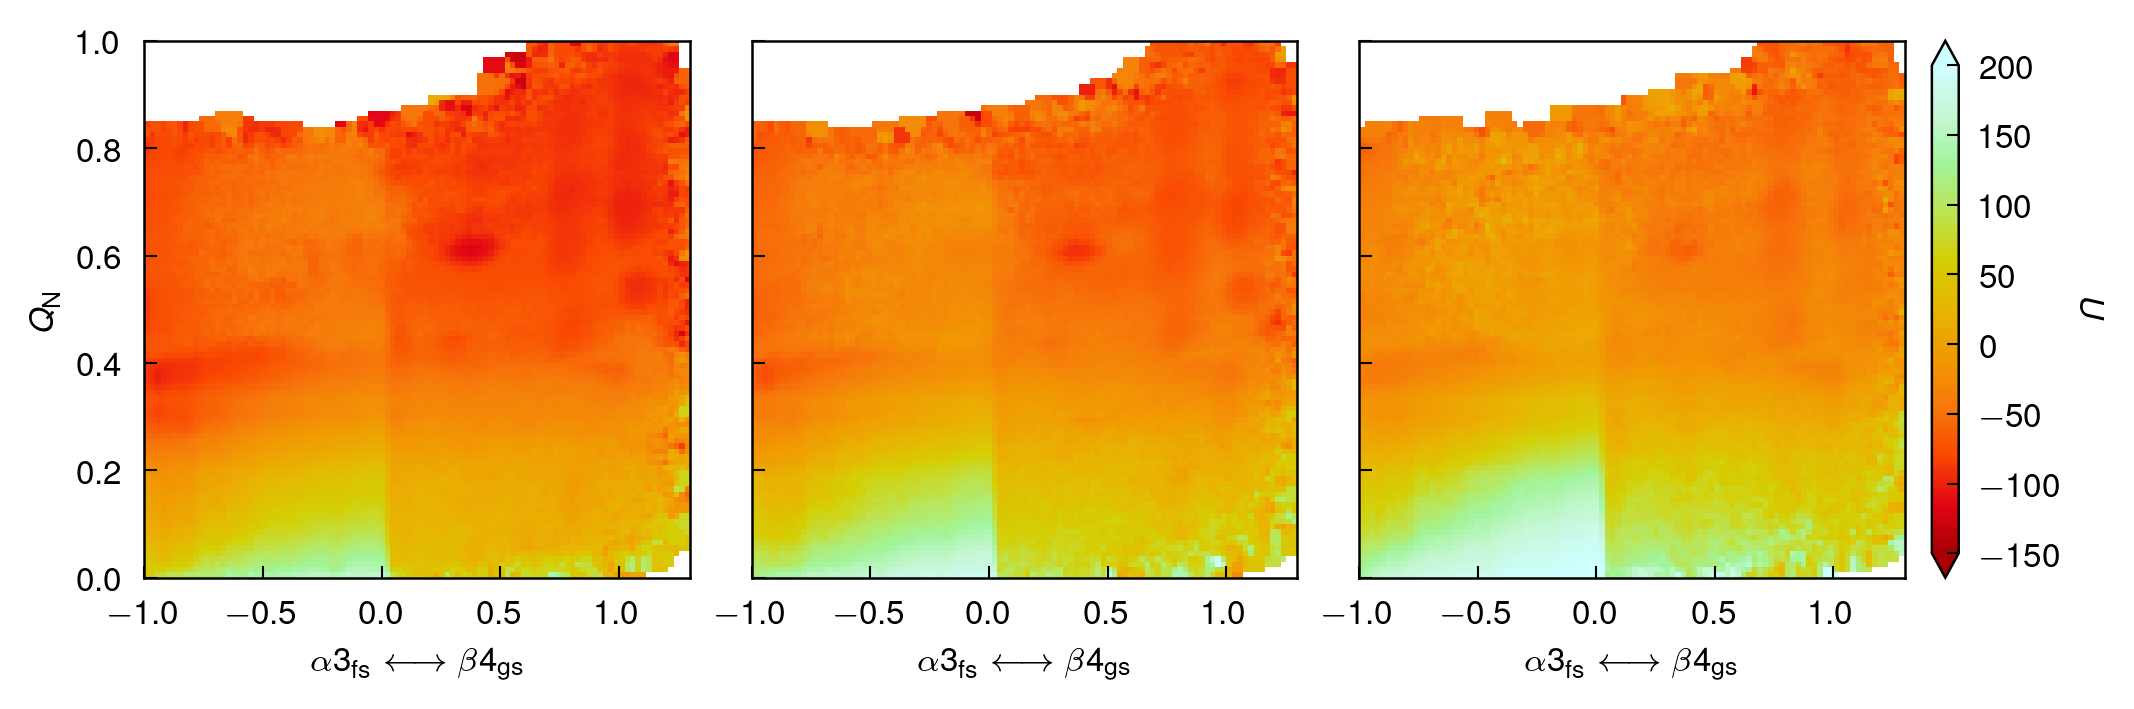

In [14]:
clines = np.arange(0, 14, 2)
fig, axes = plt.subplots(
    nrows=1, ncols=3, figsize=(7, 2.25), dpi=300, sharex=True, sharey=True, constrained_layout=True
)
cv1, cv2 = "blue", "q_core"
xe = np.linspace(*lims[cv1], 101)
ye = np.linspace(*lims[cv2], 101)
xc = (xe[:-1] + xe[1:]) / 2
yc = (ye[:-1] + ye[1:]) / 2
for ax, cvs, sample_w in zip(axes, cvs_all_ts, weights_all_ts):
    cv1_delay = cvs[cv1]
    cv2_delay = cvs[cv2]
    w = extq.projection.density2d(
        cv1_delay,
        cv2_delay,
        np.broadcast_to(sample_w[..., None], cv1_delay.shape),
        xe,
        ye,
    )
    w = scipy.ndimage.gaussian_filter(w, sigma=0.5, mode="constant")
    ew = extq.projection.density2d(
        cv1_delay,
        cv2_delay,
        np.asarray(cvs["pot"]) * sample_w[..., None],
        xe,
        ye,
    )
    ew = scipy.ndimage.gaussian_filter(ew, sigma=0.5, mode="constant")
    pc = ax.pcolormesh(xc, yc, (ew / w).T, cmap="incandescent_r", rasterized=True, vmin=-150, vmax=200)
    # ax.contour(xc, yc, pmf.T, colors="black", levels=clines, linewidths=0.5)
    ax.set_xlabel(labels[cv1])
    ax.set_ylabel(labels[cv2])
    ax.label_outer()
cb = plt.colorbar(pc, ax=axes[-1], extend="both")
cb.set_label(label="$U$", rotation=-90, labelpad=10)

plt.show()
# plt.savefig("../../dga/figures/pmfs_qgs_qfs_ts.pdf", bbox_inches='tight', dpi=400)

/scratch/local/jobs/18029147/ipykernel_929453/3180310217.py:29: RuntimeWarning: invalid value encountered in divide
  pc = ax.pcolormesh(xc, yc, (ew / w).T, cmap="incandescent_r", rasterized=True, vmin=-150, vmax=200)


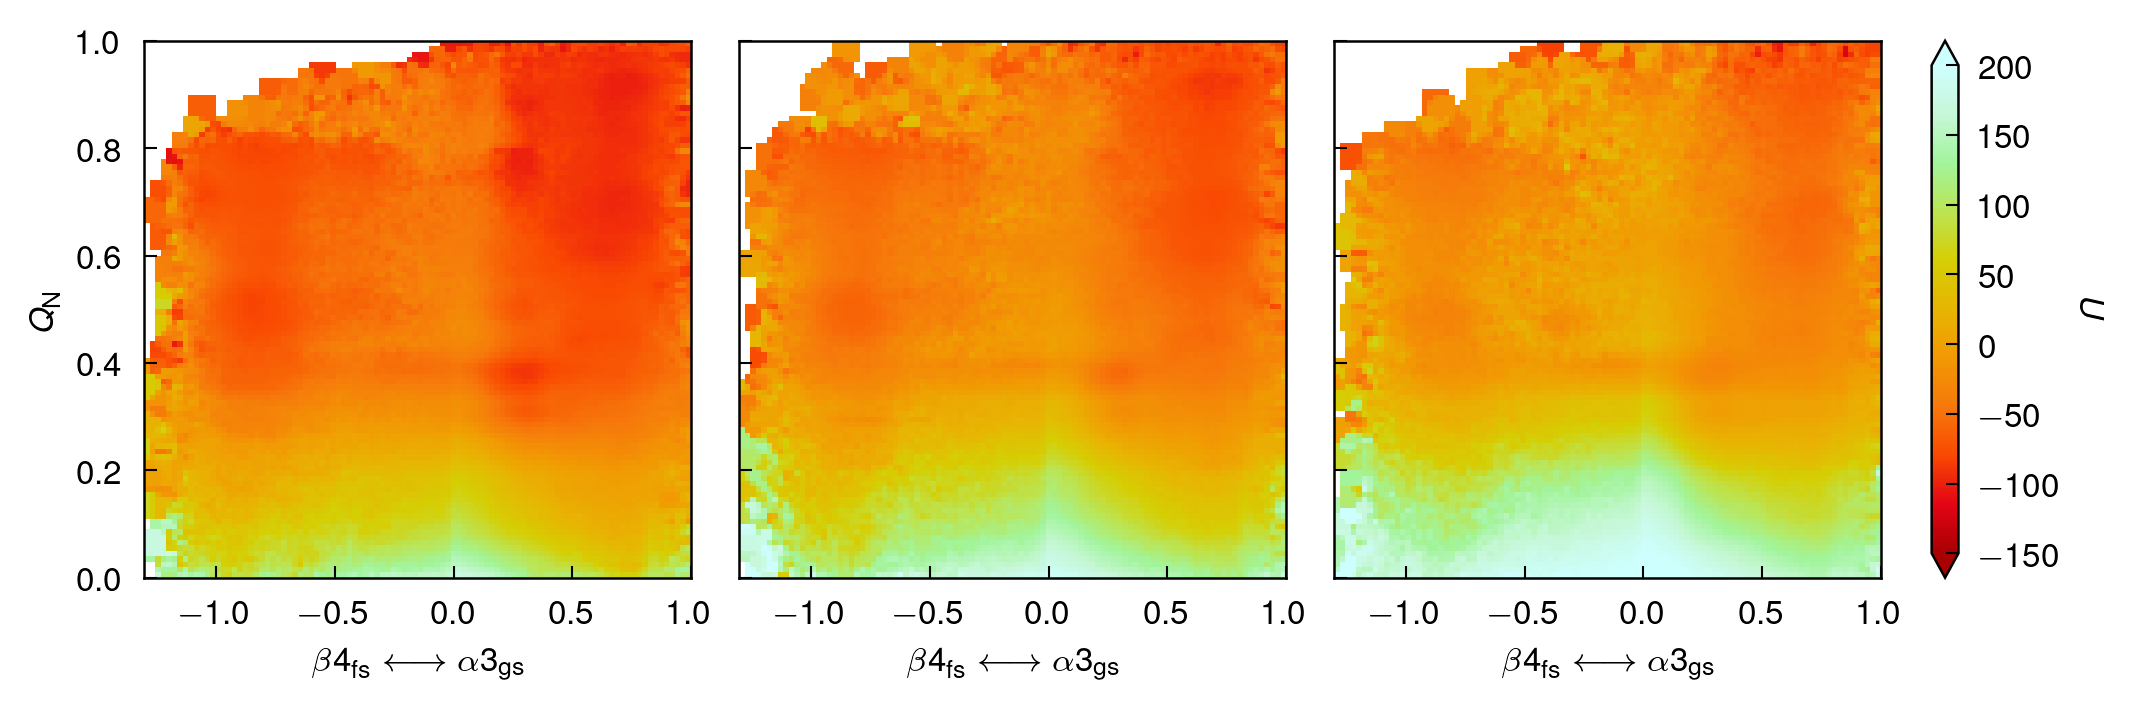

In [15]:
clines = np.arange(0, 14, 2)
fig, axes = plt.subplots(
    nrows=1, ncols=3, figsize=(7, 2.25), dpi=300, sharex=True, sharey=True, constrained_layout=True
)
cv1, cv2 = "green", "q_core"
xe = np.linspace(*lims[cv1], 101)
ye = np.linspace(*lims[cv2], 101)
xc = (xe[:-1] + xe[1:]) / 2
yc = (ye[:-1] + ye[1:]) / 2
for ax, cvs, sample_w in zip(axes, cvs_all_ts, weights_all_ts):
    cv1_delay = cvs[cv1]
    cv2_delay = cvs[cv2]
    w = extq.projection.density2d(
        cv1_delay,
        cv2_delay,
        np.broadcast_to(sample_w[..., None], cv1_delay.shape),
        xe,
        ye,
    )
    w = scipy.ndimage.gaussian_filter(w, sigma=0.5, mode="constant")
    ew = extq.projection.density2d(
        cv1_delay,
        cv2_delay,
        np.asarray(cvs["pot"]) * sample_w[..., None],
        xe,
        ye,
    )
    ew = scipy.ndimage.gaussian_filter(ew, sigma=0.5, mode="constant")
    pc = ax.pcolormesh(xc, yc, (ew / w).T, cmap="incandescent_r", rasterized=True, vmin=-150, vmax=200)
    # ax.contour(xc, yc, pmf.T, colors="black", levels=clines, linewidths=0.5)
    ax.set_xlabel(labels[cv1])
    ax.set_ylabel(labels[cv2])
    ax.label_outer()
cb = plt.colorbar(pc, ax=axes[-1], extend="both")
cb.set_label(label="$U$", rotation=-90, labelpad=10)

plt.show()
# plt.savefig("../../dga/figures/pmfs_qgs_qfs_ts.pdf", bbox_inches='tight', dpi=400)

/scratch/local/jobs/18029147/ipykernel_929453/3519972259.py:29: RuntimeWarning: invalid value encountered in divide
  pc = ax.pcolormesh(xc, yc, (ew / w).T, cmap="incandescent_r", rasterized=True, vmin=-150, vmax=200)


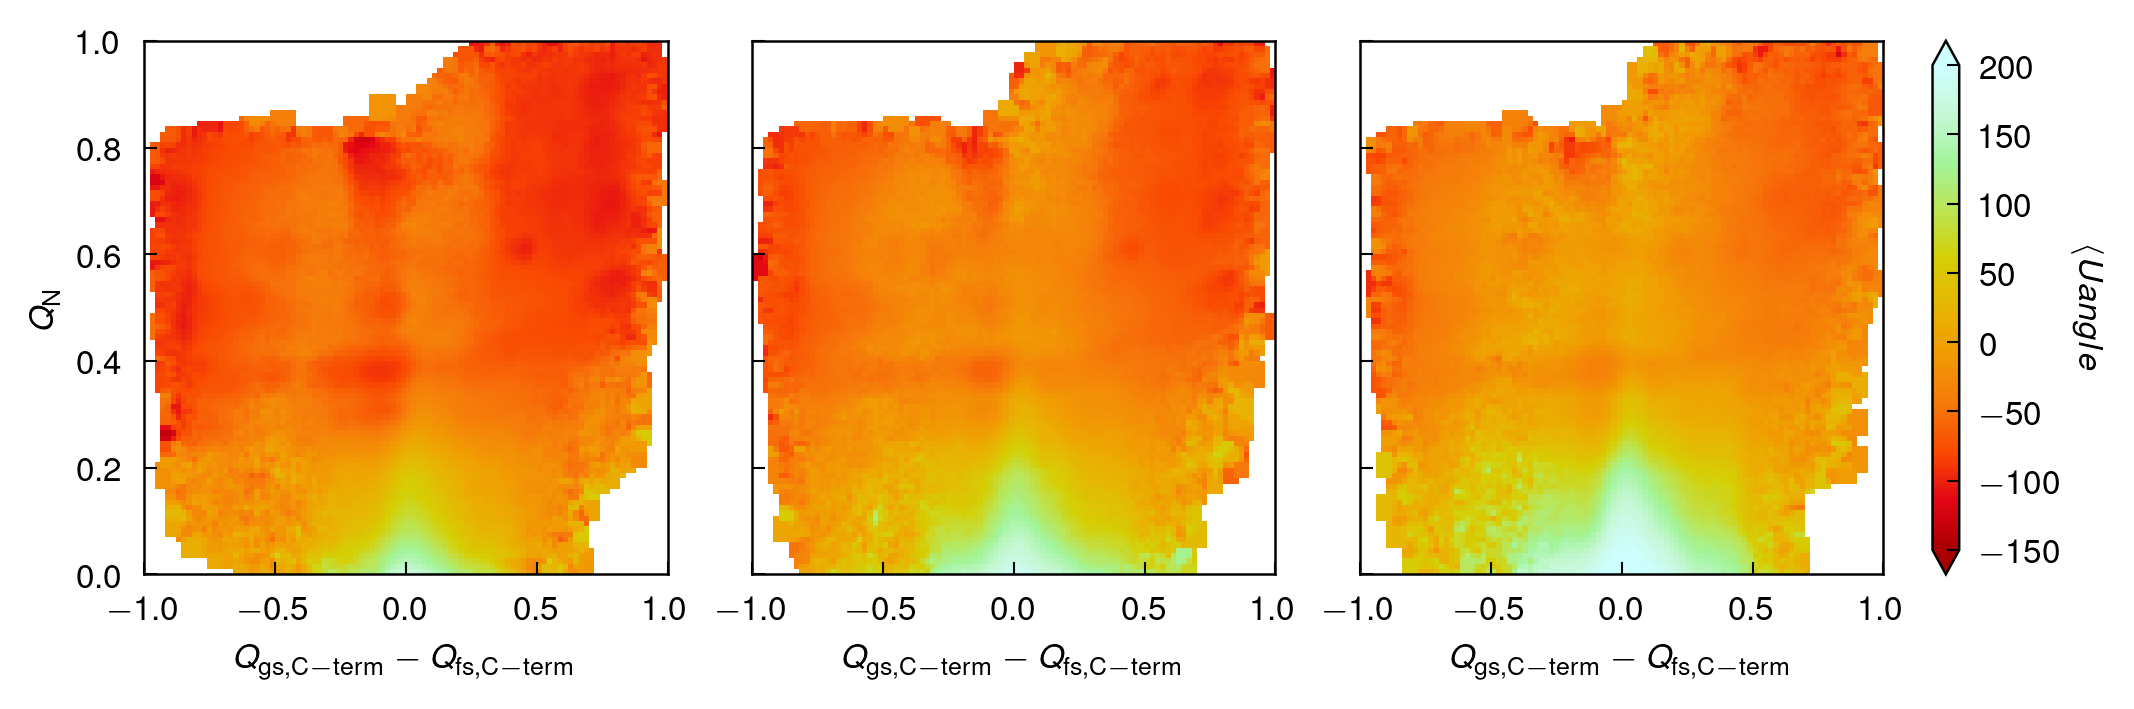

In [16]:
clines = np.arange(0, 14, 2)
fig, axes = plt.subplots(
    nrows=1, ncols=3, figsize=(7, 2.25), dpi=300, sharex=True, sharey=True, constrained_layout=True
)
cv2 = "q_core"
xe = np.linspace(-1, 1, 101)
ye = np.linspace(*lims[cv2], 101)
xc = (xe[:-1] + xe[1:]) / 2
yc = (ye[:-1] + ye[1:]) / 2
for ax, cvs, sample_w in zip(axes, cvs_all_ts, weights_all_ts):
    cv1_delay = cvs["q_gs"] - cvs["q_fs"]
    cv2_delay = cvs[cv2]
    w = extq.projection.density2d(
        cv1_delay,
        cv2_delay,
        np.broadcast_to(sample_w[..., None], cv1_delay.shape),
        xe,
        ye,
    )
    w = scipy.ndimage.gaussian_filter(w, sigma=0.5, mode="constant")
    ew = extq.projection.density2d(
        cv1_delay,
        cv2_delay,
        np.asarray(cvs["pot"]) * sample_w[..., None],
        xe,
        ye,
    )
    ew = scipy.ndimage.gaussian_filter(ew, sigma=0.5, mode="constant")
    pc = ax.pcolormesh(xc, yc, (ew / w).T, cmap="incandescent_r", rasterized=True, vmin=-150, vmax=200)
    ax.set_xlabel(r"$Q_{\mathrm{gs,C-term}}-Q_{\mathrm{fs,C-term}}$")
    ax.set_ylabel(labels[cv2])
    ax.label_outer()
cb = plt.colorbar(pc, ax=axes[-1], extend="both")
cb.set_label(label="$\langle U \rangle$", rotation=-90, labelpad=10)

plt.show()
# plt.savefig("../../dga/figures/pmfs_qgs_qfs_ts.pdf", bbox_inches='tight', dpi=400)

# energies ins tates

In [17]:
def define_states(cvs):
    in_fs = (
        (cvs["green"] < -0.65)
        & (cvs["blue"] < -0.8)
        & (cvs["orange"] < -0.85)
        & (cvs["q_fs_all"] > 0.61)
        & (cvs["q_fs"] > 0.75)
        & (cvs["f_rmsds"] < 0.35)
        & (cvs["q_core"] > 0.65)
    )
    in_gs = (
        (cvs["green"] > 0.55)
        & (cvs["blue"] > 0.90)
        & (cvs["orange"] > 0.75)
        & (cvs["q_gs_all"] > 0.62)
        & (cvs["q_gs"] > 0.65)
        & (cvs["p_rmsds"] < 0.45)
        & (cvs["q_core"] > 0.7)
        & (cvs["c0"] > 0.5)
    )
    return in_fs, in_gs

In [18]:
in_fs_ts, in_gs_ts = [], []
for cvs in cvs_all_ts:
    in_fs, in_gs = define_states(cvs)
    in_fs_ts.append(in_fs)
    in_gs_ts.append(in_gs)

In [19]:
def pi_avg_state(cv, w, in_state):
    return np.mean((cv * w[..., None])[in_state]) / np.mean(np.repeat(w[..., None], 1001, axis=1)[in_state])

In [20]:
def g_state(w, in_state):
    return -np.log(np.sum(np.repeat(w[..., None], 1001, axis=1)[in_state]))

In [21]:
for fs, gs, cvs, w, t in zip(in_fs_ts, in_gs_ts, cvs_all_ts, weights_all_ts, (0.87, 0.89, 0.91)):
    avg_pot_fs = pi_avg_state(cvs["pot"], w, fs)
    var_pot_fs = pi_avg_state(cvs["pot"] ** 2, w, fs) - avg_pot_fs**2
    avg_pot_gs = pi_avg_state(cvs["pot"], w, gs)
    var_pot_gs = pi_avg_state(cvs["pot"] ** 2, w, gs) - avg_pot_gs**2
    avg_pot = pi_avg_state(cvs["pot"], w, 1)
    var_pot = pi_avg_state(cvs["pot"] ** 2, w, 1) - avg_pot**2
    print(f"<E>/T = {avg_pot / t:.1f} +/- {np.sqrt(var_pot) / t:.1f}, C = {var_pot / t**2:.1f}")
    print(
        f"<E>/T fs  = {avg_pot_fs / t:.1f} +/- {np.sqrt(var_pot_fs) / t:.1f}, <E>/T gs = {avg_pot_gs / t:.1f} +/- {np.sqrt(var_pot_gs) / t:.1f}, diff = {(avg_pot_fs - avg_pot_gs) / t:.1f}"
    )
    g_fs = g_state(w, fs)
    g_gs = g_state(w, gs)
    print(f"G/T fs = {g_fs / t:.3f}, G/T gs = {g_gs / t:.3f}, diff = {(g_fs - g_gs) / t:.3f}:")
    print("")

<E>/T = -115.0 +/- 27.2, C = 738.9
<E>/T fs  = -91.9 +/- 30.4, <E>/T gs = -115.3 +/- 30.0, diff = 23.4
G/T fs = -13.027, G/T gs = -12.207, diff = -0.821:

<E>/T = -84.2 +/- 30.1, C = 908.7
<E>/T fs  = -69.8 +/- 29.7, <E>/T gs = -94.4 +/- 29.0, diff = 24.6
G/T fs = -10.970, G/T gs = -10.502, diff = -0.468:

<E>/T = -56.2 +/- 31.5, C = 992.8
<E>/T fs  = -48.2 +/- 29.2, <E>/T gs = -74.7 +/- 30.2, diff = 26.5
G/T fs = -7.755, G/T gs = -8.026, diff = 0.271:



In [22]:
for qp, cvs, w, t in zip(qp_all_ts, cvs_all_ts, weights_all_ts, (0.87, 0.89, 0.91)):
    qp = np.asarray(qp)
    avg_pot_fs = pi_avg_state(cvs["pot"], w, qp > 0.9)
    var_pot_fs = pi_avg_state(cvs["pot"] ** 2, w, qp > 0.9) - avg_pot_fs**2
    avg_pot_gs = pi_avg_state(cvs["pot"], w, qp < 0.1)
    var_pot_gs = pi_avg_state(cvs["pot"] ** 2, w, qp < 0.1) - avg_pot_gs**2
    avg_pot = pi_avg_state(cvs["pot"], w, 1)
    var_pot = pi_avg_state(cvs["pot"] ** 2, w, 1) - avg_pot**2
    print(f"<E> = {avg_pot:.1f} +/- {np.sqrt(var_pot):.1f}, C = {var_pot / t**2:.1f}")
    print(
        f"<E> q>0.9  = {avg_pot_fs:.1f} +/- {np.sqrt(var_pot_fs):.1f}, <E> q<0.1 = {avg_pot_gs:.1f} +/- {np.sqrt(var_pot_gs):.1f}, diff = {avg_pot_fs - avg_pot_gs:.1f}"
    )
    g_fs = g_state(w, qp > 0.9)
    g_gs = g_state(w, qp < 0.1)
    print(f"G fs = {g_fs:.1f}, G gs = {g_gs:.1f}, diff = {g_fs - g_gs:.1f}:")
    print("")

<E> = -100.0 +/- 23.6, C = 738.9
<E> q>0.9  = -73.2 +/- 29.1, <E> q<0.1 = -83.7 +/- 32.6, diff = 10.5
G fs = -12.0, G gs = -13.7, diff = 1.8:

<E> = -74.9 +/- 26.8, C = 908.7
<E> q>0.9  = -55.1 +/- 29.2, <E> q<0.1 = -58.3 +/- 41.1, diff = 3.2
G fs = -10.4, G gs = -13.0, diff = 2.6:

<E> = -51.2 +/- 28.7, C = 992.8
<E> q>0.9  = -36.3 +/- 30.1, <E> q<0.1 = 53.6 +/- 96.5, diff = -90.0
G fs = -7.7, G gs = -14.5, diff = 6.7:



In [23]:
def kdesum1d(
    x,
    w,
    *,
    xmin=None,
    xmax=None,
    xstd=None,
    nx=100,
    cut=4.0,
):
    """Compute a 1D kernel density estimate.

    This function histograms the data, then uses a Gaussian filter to
    approximate a kernel density estimate with a Gaussian kernel.

    Parameters
    ----------
    x : ndarray or list/tuple of ndarray
        Coordinates of each frame.
    w : ndarray or list/tuple of ndarray
        Weight or value of each frame. The output is the sum of these
        values in each bin, after smoothing.
    xmin, xmax : float, optional
        Limits of kernel density estimate. If None, takes the min/max
        of the data along the coordinate.
    xstd : float, optional
        Standard deviation of the Gaussian filter. If None, these are
        set to (xmax - xmin) / nx. Increase this to smooth the results more.
    nx : int, optional
        Number of bins in each dimension. This should be set as high as
        reasonable, since xstd takes care of the smoothing.
    cut : float, optional
        Number of standard deviations at which to truncate the Gaussian
        filter. The default, 4, usually doesn't need to be changed.

    Returns
    -------
    kde : (nx,) ndarray
        Kernel density estimate, given as bins.
    xedges : (nx+1,) ndarray
        Bin edges along the x dimension.

    """

    # flatten input to 1D arrays
    x = _flatten(x)
    w = _flatten(w)

    # limits
    _xmin = np.min(x)
    _xmax = np.max(x)
    if xmin is None:
        xmin = _xmin
    if xmax is None:
        xmax = _xmax

    # separation between grid points
    xsep = (xmax - xmin) / nx

    # number of grid points to pad the boundaries,
    # since the Gaussian filter extends beyond the boundaries
    # usually overestimates the padding, but whatever
    ax = max(0, int(np.ceil((xmin - _xmin) / xsep + 1e-6)))
    bx = max(0, int(np.ceil((_xmax - xmax) / xsep + 1e-6)))

    # output bin edges
    xedges = np.linspace(xmin, xmax, nx + 1)

    # bin edges, with the added padding
    xedges_padded = np.concatenate(
        [
            xmin + xsep * np.arange(-ax, 0),
            xedges,
            xmax + xsep * np.arange(1, bx + 1),
        ]
    )
    assert np.allclose(xedges_padded[1:] - xedges_padded[:-1], xsep)
    assert xedges_padded[0] <= _xmin and _xmax <= xedges_padded[-1]

    # construct 2D histogram on padded edges
    hist_padded, _ = np.histogram(x, weights=w, bins=xedges_padded)
    # Gaussian kernel parameters
    if xstd is None:
        xstd = xsep

    # apply Gaussian filter to histogram
    kde_padded = scipy.ndimage.gaussian_filter(
        hist_padded,
        sigma=(xstd / xsep),  # in units of grid points
        mode="constant",
        truncate=cut,
    )

    # remove the padding
    assert ax + nx + bx == kde_padded.shape[0]
    kde = kde_padded[ax : ax + nx]
    return kde, xedges


def _flatten(a):
    if isinstance(a, np.ndarray):
        # avoid creating a new array (and using twice the memory)
        return np.ravel(a)
    else:
        return np.ravel(np.concatenate(a))

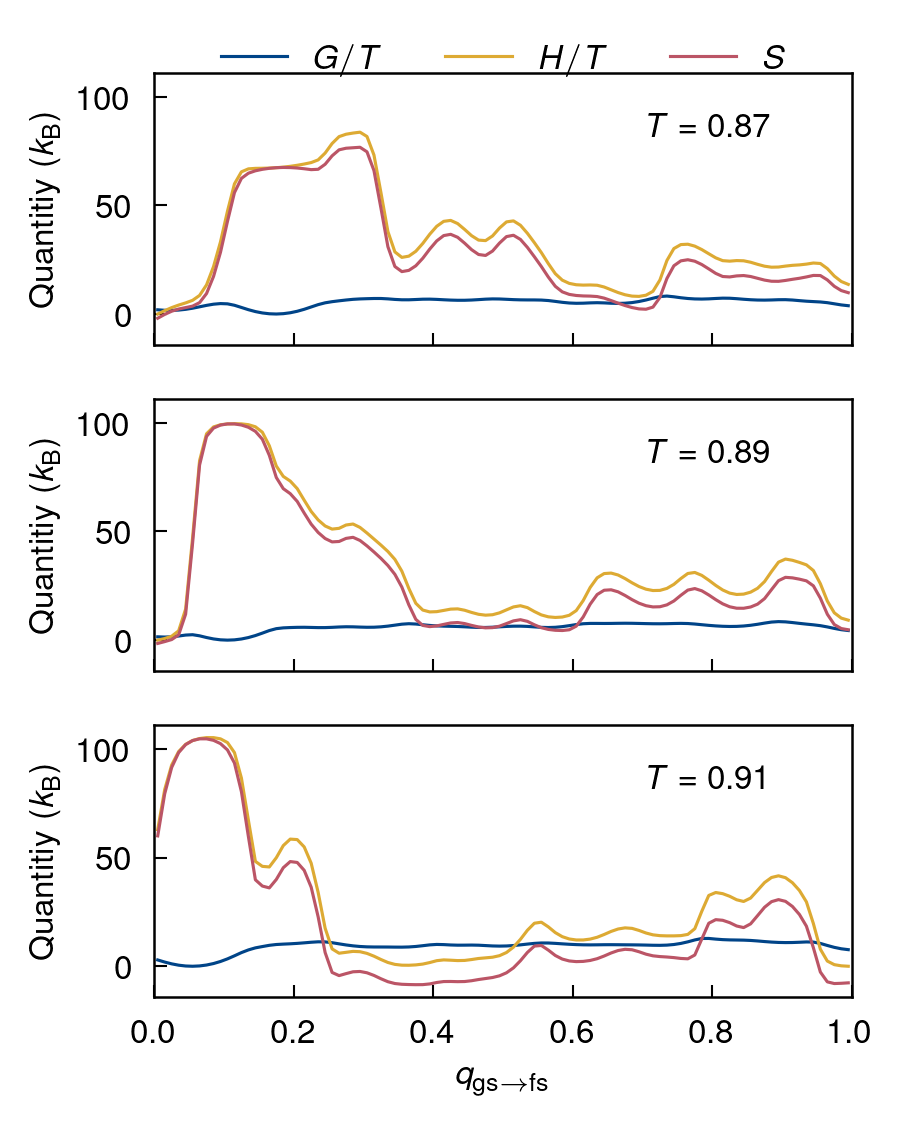

In [24]:
# plot over committor
fig, axes = plt.subplots(3, 1, figsize=(3, 4), sharex=True, sharey=True, dpi=300)

lag, mem = 100, 1
xstd = 0.02
xe = np.linspace(0, 1, 101)
xc = (xe[1:] + xe[:-1]) / 2
for qp, w, cvs, ax, t in zip(qp_all_ts, weights_all_ts, cvs_all_ts, axes, [0.87, 0.89, 0.91]):
    q = np.asarray(qp)[..., :-lag]
    pot = cvs["pot"][..., :-lag]

    w = np.broadcast_to(w[..., None], q.shape)
    hist, _ = kdesum1d(q, w, xmin=0, xmax=1, xstd=xstd, nx=100)
    min_energy = np.min(-np.log(hist))
    pmf = -np.log(hist) - min_energy

    potw, _ = kdesum1d(q, w * pot, xmin=0, xmax=1, xstd=xstd, nx=100)
    potw /= hist
    potw -= np.min(potw)
    ax.plot(xc, pmf / t, label=r"$G / T$")
    ax.plot(xc, potw / t, label=r"$H / T$")
    ax.plot(xc, -(pmf - potw) / t, label=r"$S$")
    ax.set_xlabel(r"$q_{\mathrm{gs}\rightarrow\mathrm{fs}}$")
    ax.set_ylabel(r"Quantitiy ($k_{\mathrm{B}}$)")
    ax.set_xlim([0, 1])
    ax.label_outer()
    pplt.text(0.8, 0.8, f"$T = {t}$", transform=ax.transAxes)
axes[0].legend(bbox_to_anchor=(0.5, 1.05), loc="center", ncols=3)
plt.show()

# populations along q

In [25]:
def pop_state(w, in_state):
    return np.sum(np.repeat(w[..., None], 1001, axis=1)[in_state]) / (np.sum(w[..., None]) * 1001)

In [28]:
for cvs, w in zip(cvs_all_ts, weights_all_ts):
    in_unfolded = (
        (np.abs(cvs["blue"]) < 0.5)
        & (np.abs(cvs["green"]) < 0.5)
        & (np.abs(cvs["orange"]) < 0.5)
        & (cvs["q_core"] < 0.16)
    )
    print(pop_state(w, in_unfolded))

0.05222487997445291
0.09137281587885915
0.19023076659559826


In [29]:
for cvs, w in zip(cvs_all_ts, weights_all_ts):
    in_unfolded = (cvs["q_gs_all"] < 0.2) & (cvs["q_fs_all"] < 0.2) & (cvs["q_core"] < 0.16)
    print(pop_state(w, in_unfolded))

0.08797778520560341
0.1397240209707286
0.2618048393973734


In [31]:
# plot population of unfolded state
def in_unfolded(cvs):
    return (
        (np.abs(cvs["blue"]) < 0.5)
        & (np.abs(cvs["green"]) < 0.5)
        & (np.abs(cvs["orange"]) < 0.5)
        & (cvs["q_core"] < 0.16)
    )


def in_fs(cvs):
    return (
        (cvs["green"] < -0.65)
        & (cvs["blue"] < -0.8)
        & (cvs["orange"] < -0.85)
        & (cvs["q_fs_all"] > 0.61)
        & (cvs["q_fs"] > 0.75)
        & (cvs["f_rmsds"] < 0.35)
        & (cvs["q_core"] > 0.65)
    )


def in_gs(cvs):
    return (
        (cvs["green"] > 0.55)
        & (cvs["blue"] > 0.90)
        & (cvs["orange"] > 0.75)
        & (cvs["q_gs_all"] > 0.62)
        & (cvs["q_gs"] > 0.65)
        & (cvs["p_rmsds"] < 0.45)
        & (cvs["q_core"] > 0.7)
        & (cvs["c0"] > 0.5)
    )

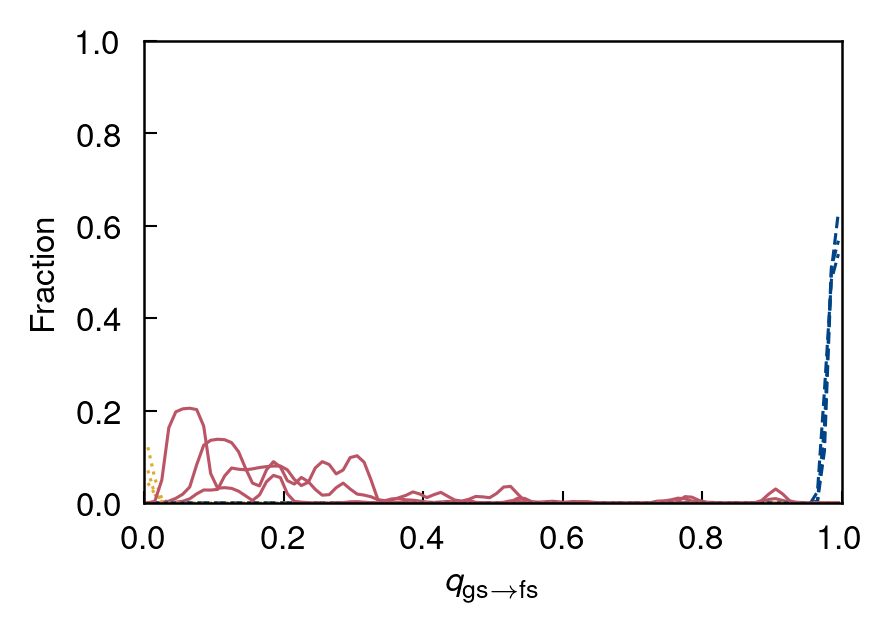

In [32]:
fig = plt.figure(figsize=(3, 2), dpi=300)

lag, mem = 100, 1
xstd = 0.01
nx = 100
handles = []
labs = ["low", "medium", "high"]
linestyles = ['--', ':', '-']
for qp, w, cvs, label in zip(qp_all_ts, weights_all_ts, cvs_all_ts, labs):
    q = np.asarray(qp)[..., :-lag]
    w = np.broadcast_to(w[..., None], q.shape)
    for state_fn, ls in zip((in_fs, in_gs, in_unfolded), linestyles):
        cv = state_fn(cvs)
        numer, xe = kdesum1d(q, cv[..., :-lag] * w, xmin=0, xmax=1, xstd=xstd, nx=nx)
        denom, _ = kdesum1d(q, w, xmin=0, xmax=1, xstd=xstd, nx=nx)
        mean = numer / denom
        xc = (xe[1:] + xe[:-1]) / 2
        line = plt.plot(xc, mean, ls=ls)
    # handles.append(line)
plt.xlabel(r"$q_{\mathrm{gs}\rightarrow\mathrm{fs}}$")
plt.ylabel("Fraction")
plt.xlim([0, 1])
plt.ylim([0, 1])
# plt.legend(title="Temperature", bbox_to_anchor=(0.5, 1.1), loc="center", ncols=3)
# fig.savefig("../../dga/figures/qp_p7072_ts.pdf", bbox_inches='tight')
plt.show()

# contacts?

In [42]:
raw_contacts_87 = load_cv(f"{home_dir}/dga//new_87/data/raw_contacts")

In [44]:
raw_contacts_87.shape

(22826, 1001, 332)

In [45]:
from itertools import product

In [46]:
gs_file = f"/project/dinner/scguo/kaiB/dga/new_91/00/00001/cis/gs_p2.5_00_00.run.h5"
gs_traj = md.load(gs_file)

featurizer = pyemma.coordinates.featurizer(gs_traj.top)
# fmt: off
resids = np.array([3, 9, 11, 13, 16, 23, 33, 38, 41, 43, 45, 47, 51, 56, 59, 63, 65, 67, 70, 72, 75, 78, 81, 84, 87, 90, 93,]) - 1
# fmt: on
residue_pairs = [(i, j) for (i, j) in product(resids, resids) if abs(i - j) > 3 and i > j]
featurizer.add_residue_mindist(residue_pairs=residue_pairs, threshold=0.45)

print(np.count_nonzero(featurizer.describe()))

/beagle3/dinner/scguo/envs/md/lib/python3.11/site-packages/mdtraj/core/trajectory.py:439: UserWarning: top= kwargs ignored since this file parser does not support it
  warnings.warn('top= kwargs ignored since this file parser does not support it')


332


In [47]:
def make_contact_map(contact_values):
    contact_map = np.full([94, 94], np.nan)
    for id in range(332):
        feature = featurizer.describe()[id]
        words = feature.split()
        res1, res2 = words[2], words[4]
        resid1, resid2 = int(res1[3:]), int(res2[3:])
        contact_map[resid1, resid2] = contact_values[id]
        contact_map[resid2, resid1] = contact_values[id]
    return contact_map

In [48]:
print(featurizer.describe())

['RES_DIST (closest-heavy) VAL8 - PRO2', 'RES_DIST (closest-heavy) LYS10 - PRO2', 'RES_DIST (closest-heavy) TYR12 - PRO2', 'RES_DIST (closest-heavy) TYR12 - VAL8', 'RES_DIST (closest-heavy) GLY15 - PRO2', 'RES_DIST (closest-heavy) GLY15 - VAL8', 'RES_DIST (closest-heavy) GLY15 - LYS10', 'RES_DIST (closest-heavy) ARG22 - PRO2', 'RES_DIST (closest-heavy) ARG22 - VAL8', 'RES_DIST (closest-heavy) ARG22 - LYS10', 'RES_DIST (closest-heavy) ARG22 - TYR12', 'RES_DIST (closest-heavy) ARG22 - GLY15', 'RES_DIST (closest-heavy) GLU32 - PRO2', 'RES_DIST (closest-heavy) GLU32 - VAL8', 'RES_DIST (closest-heavy) GLU32 - LYS10', 'RES_DIST (closest-heavy) GLU32 - TYR12', 'RES_DIST (closest-heavy) GLU32 - GLY15', 'RES_DIST (closest-heavy) GLU32 - ARG22', 'RES_DIST (closest-heavy) GLY37 - PRO2', 'RES_DIST (closest-heavy) GLY37 - VAL8', 'RES_DIST (closest-heavy) GLY37 - LYS10', 'RES_DIST (closest-heavy) GLY37 - TYR12', 'RES_DIST (closest-heavy) GLY37 - GLY15', 'RES_DIST (closest-heavy) GLY37 - ARG22', 'RES

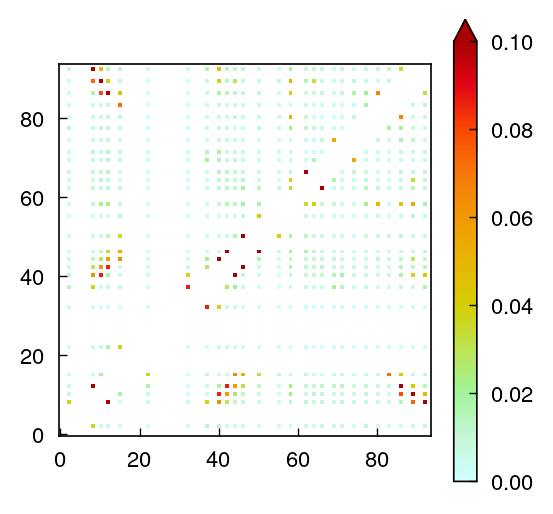

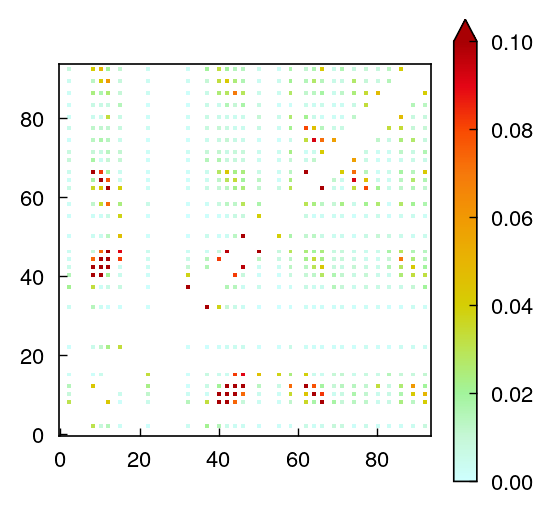

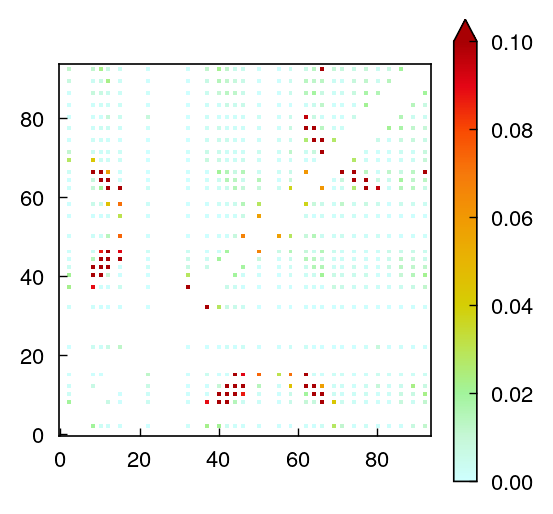

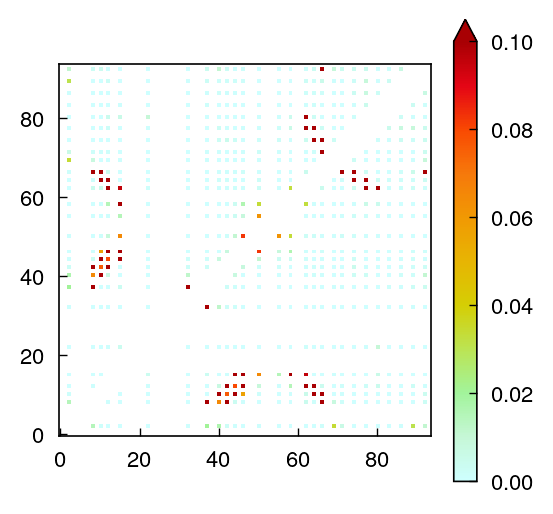

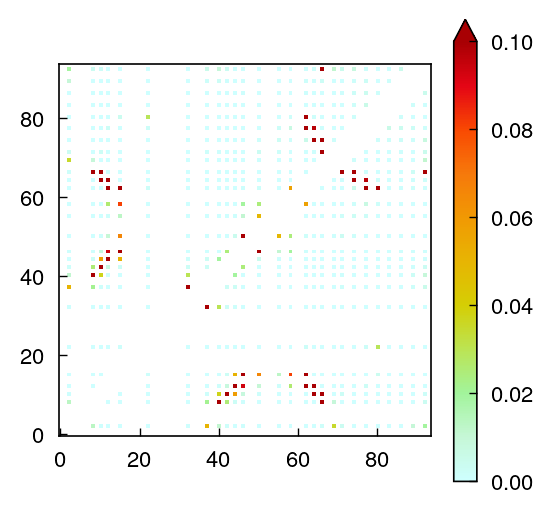

In [82]:
# show each contact map
qp = np.asarray(qp_all_ts[0])
for i in range(5):
    mask = (qp >= i * 0.2) & (qp <= (i + 1) * 0.2)
    contacts_slice = np.mean(raw_contacts_87[mask], axis=0)
    contact_map = make_contact_map(contacts_slice)
    fig = plt.figure(dpi=200)
    im = plt.imshow(contact_map, origin="lower", cmap="incandescent", vmin=0, vmax=0.1)
    plt.colorbar(im, extend="max")
    plt.show()

# currents

In [40]:
weights = np.array(np.broadcast_to(weights_all_ts[0][:, None], cvs_all_ts[0]["q_core"].shape))
lag = 10
weights[..., -lag:] = 0
in_d = ~(in_fs_ts[0] | in_gs_ts[0])
qp = np.nan_to_num(qp_all_ts[0], copy=False).clip(min=0, max=1)
qm = np.nan_to_num(qm_all_ts[0], copy=False).clip(min=0, max=1)
j = extq.tpt.current(qp, qm, weights, in_d, qp, lag)

In [41]:
j

[array([0., 0., 0., ..., 0., 0., 0.]),
 array([0., 0., 0., ..., 0., 0., 0.]),
 array([0., 0., 0., ..., 0., 0., 0.]),
 array([0., 0., 0., ..., 0., 0., 0.]),
 array([0., 0., 0., ..., 0., 0., 0.]),
 array([0., 0., 0., ..., 0., 0., 0.]),
 array([0., 0., 0., ..., 0., 0., 0.]),
 array([0., 0., 0., ..., 0., 0., 0.]),
 array([0., 0., 0., ..., 0., 0., 0.]),
 array([0., 0., 0., ..., 0., 0., 0.]),
 array([0., 0., 0., ..., 0., 0., 0.]),
 array([0., 0., 0., ..., 0., 0., 0.]),
 array([0., 0., 0., ..., 0., 0., 0.]),
 array([0., 0., 0., ..., 0., 0., 0.]),
 array([0., 0., 0., ..., 0., 0., 0.]),
 array([0., 0., 0., ..., 0., 0., 0.]),
 array([0., 0., 0., ..., 0., 0., 0.]),
 array([0., 0., 0., ..., 0., 0., 0.]),
 array([0., 0., 0., ..., 0., 0., 0.]),
 array([0., 0., 0., ..., 0., 0., 0.]),
 array([0., 0., 0., ..., 0., 0., 0.]),
 array([0., 0., 0., ..., 0., 0., 0.]),
 array([0., 0., 0., ..., 0., 0., 0.]),
 array([0., 0., 0., ..., 0., 0., 0.]),
 array([0., 0., 0., ..., 0., 0., 0.]),
 array([0., 0., 0., ..., 